In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms

0.90 - For proving that using pre-trained model works better

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm", 0.90, 12)

Found 688 files belonging to 2 classes.
Using 69 files for training.
Using 619 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (12, 4000)
Example label shape: (12,)


2024-03-23 17:25:12.009962: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-23 17:25:12.009982: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-23 17:25:12.009996: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-23 17:25:12.010026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 17:25:12.010042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

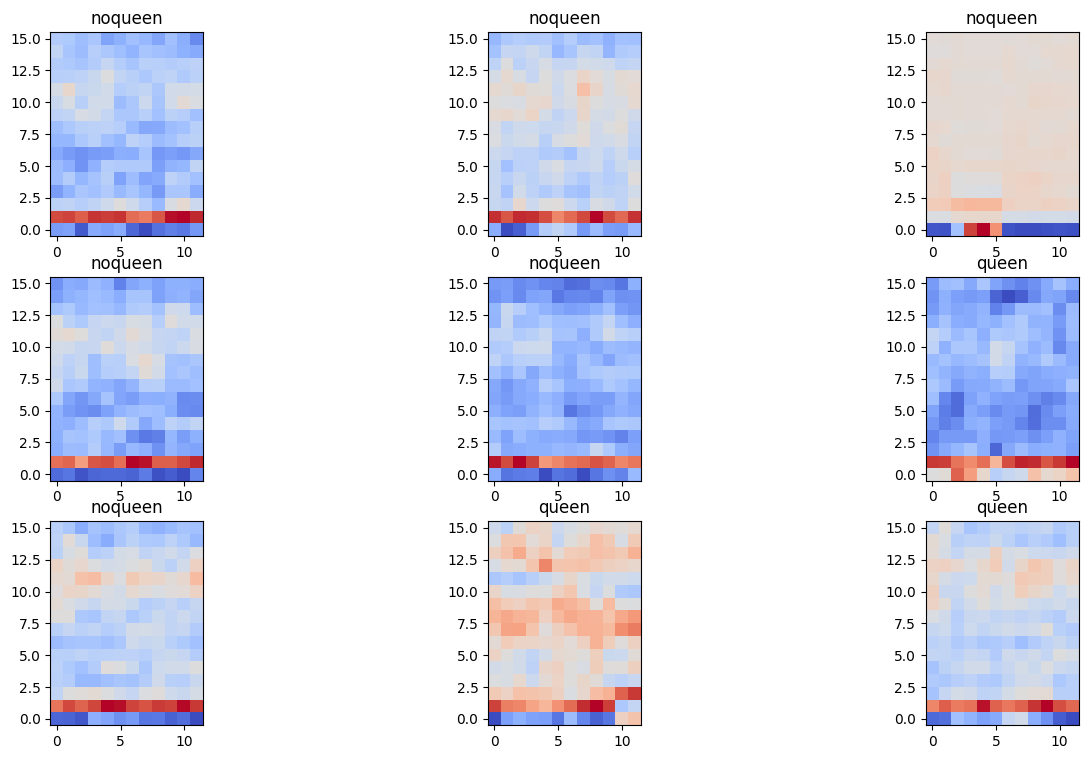

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-23 17:25:13.591804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
1/6 [====>.........................] - ETA: 2s - loss: 0.8649 - accuracy: 0.3333

2024-03-23 17:25:14.231028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


6/6 [==============================] - 2s 386ms/step - loss: 1.0682 - accuracy: 0.4203 - val_loss: 0.7805 - val_accuracy: 0.4992
Epoch 2/20
6/6 [==============================] - 0s 68ms/step - loss: 0.7181 - accuracy: 0.5362 - val_loss: 0.6203 - val_accuracy: 0.6462
Epoch 3/20
6/6 [==============================] - 0s 68ms/step - loss: 0.5656 - accuracy: 0.6812 - val_loss: 0.5952 - val_accuracy: 0.7351
Epoch 4/20
6/6 [==============================] - 0s 70ms/step - loss: 0.5061 - accuracy: 0.7246 - val_loss: 0.5793 - val_accuracy: 0.6446
Epoch 5/20
6/6 [==============================] - 0s 67ms/step - loss: 0.4896 - accuracy: 0.6957 - val_loss: 0.5502 - val_accuracy: 0.7447
Epoch 6/20
6/6 [==============================] - 0s 72ms/step - loss: 0.3644 - accuracy: 0.7681 - val_loss: 0.6474 - val_accuracy: 0.7803
Epoch 7/20
6/6 [==============================] - 0s 67ms/step - loss: 0.2492 - accuracy: 0.8986 - val_loss: 0.8410 - val_accuracy: 0.7738


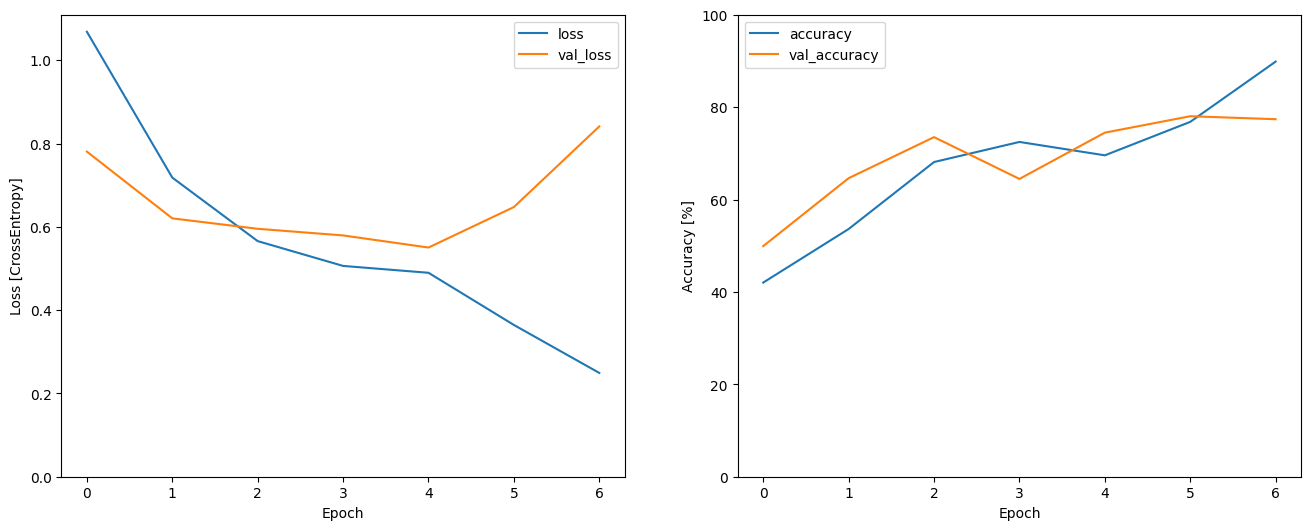

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
6/6 [==============================] - 1s 69ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.7157 - val_accuracy: 0.5008
Epoch 2/20
6/6 [==============================] - 0s 32ms/step - loss: 0.6567 - accuracy: 0.5797 - val_loss: 0.6533 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 0s 38ms/step - loss: 0.6114 - accuracy: 0.6812 - val_loss: 0.6392 - val_accuracy: 0.5994
Epoch 4/20
6/6 [==============================] - 0s 31ms/step - loss: 0.5840 - accuracy: 0.6957 - val_loss: 0.6337 - val_accuracy: 0.5267
Epoch 5/20
6/6 [==============================] - 0s 30ms/step - loss: 0.5638 - accuracy: 0.6957 - val_loss: 0.6272 - val_accuracy: 0.5250
Epoch 6/20
6/6 [==============================] - 0s 30ms/step - loss: 0.5514 - accuracy: 0.6957 - val_loss: 0.5958 - val_accuracy: 0.6834


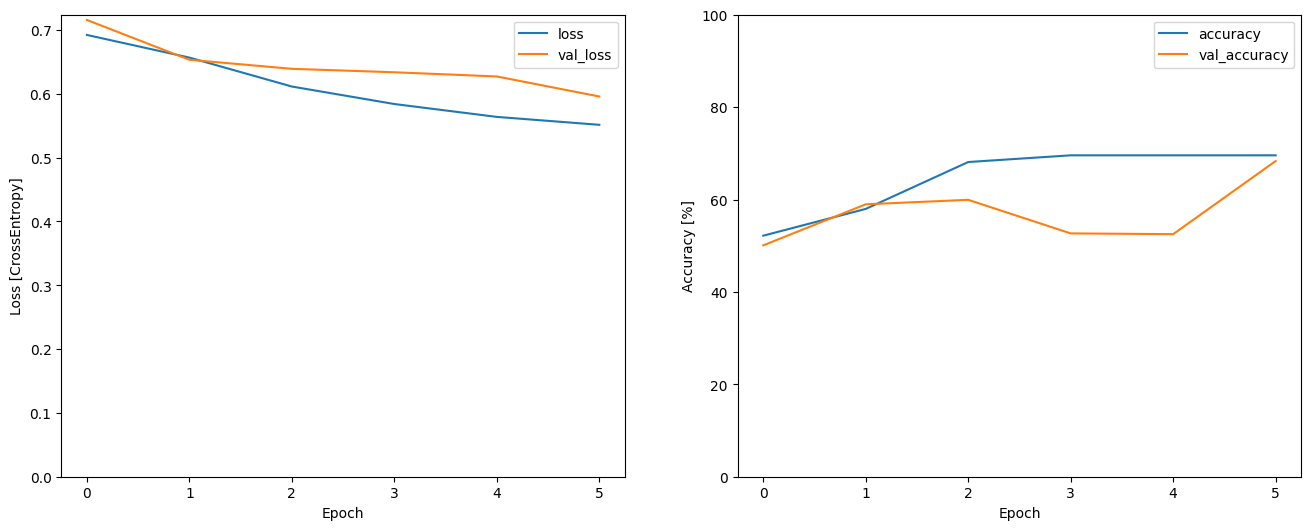

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


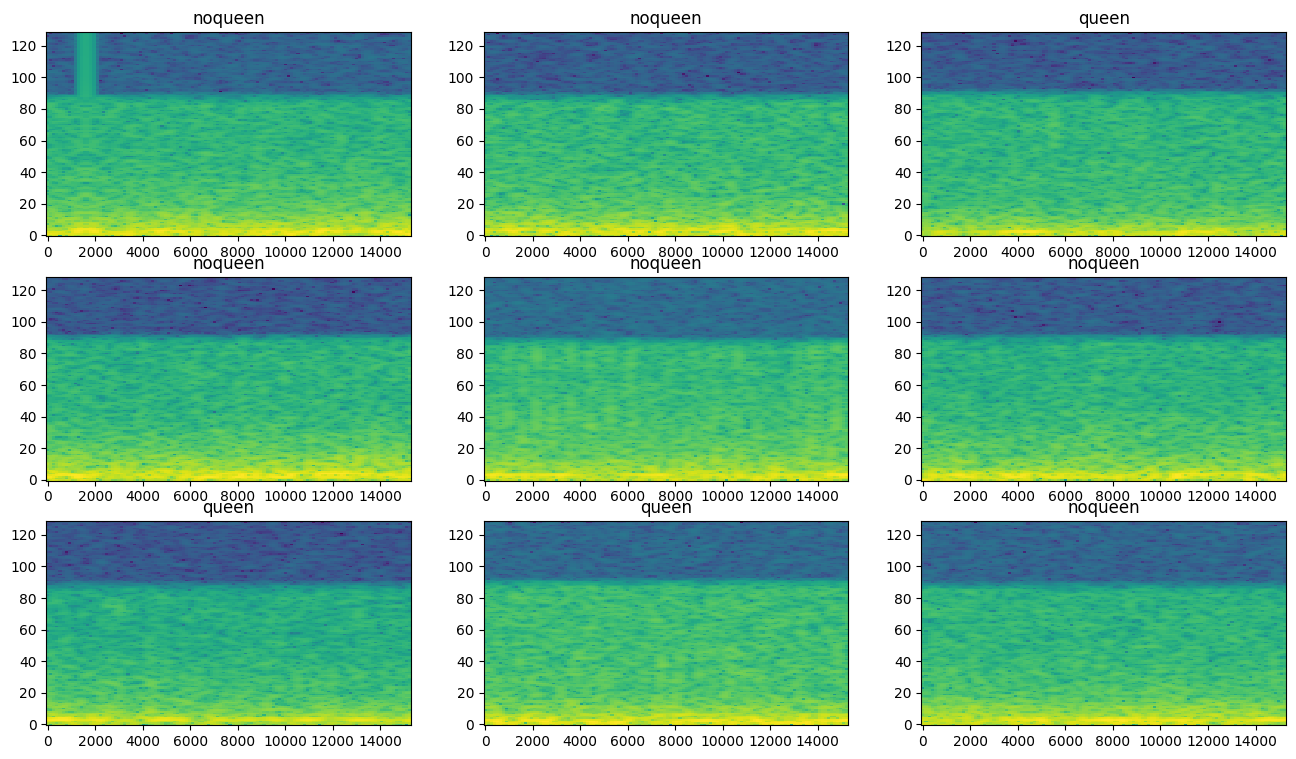

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
6/6 [==============================] - 1s 120ms/step - loss: 0.7359 - accuracy: 0.5507 - val_loss: 0.7916 - val_accuracy: 0.4992
Epoch 2/20
6/6 [==============================] - 0s 69ms/step - loss: 0.6759 - accuracy: 0.5652 - val_loss: 0.6931 - val_accuracy: 0.4830
Epoch 3/20
6/6 [==============================] - 0s 71ms/step - loss: 0.6247 - accuracy: 0.6377 - val_loss: 0.6902 - val_accuracy: 0.4879
Epoch 4/20
6/6 [==============================] - 0s 70ms/step - loss: 0.6044 - accuracy: 0.6522 - val_loss: 0.6989 - val_accuracy: 0.5008
Epoch 5/20
6/6 [==============================] - 0s 71ms/step - loss: 0.5731 - accuracy: 0.6667 - val_loss: 0.6969 - val_accuracy: 0.4911
Epoch 6/20
6/6 [==============================] - 0s 69ms/step - loss: 0.5532 - accuracy: 0.6522 - val_loss: 0.6943 - val_accuracy: 0.4911


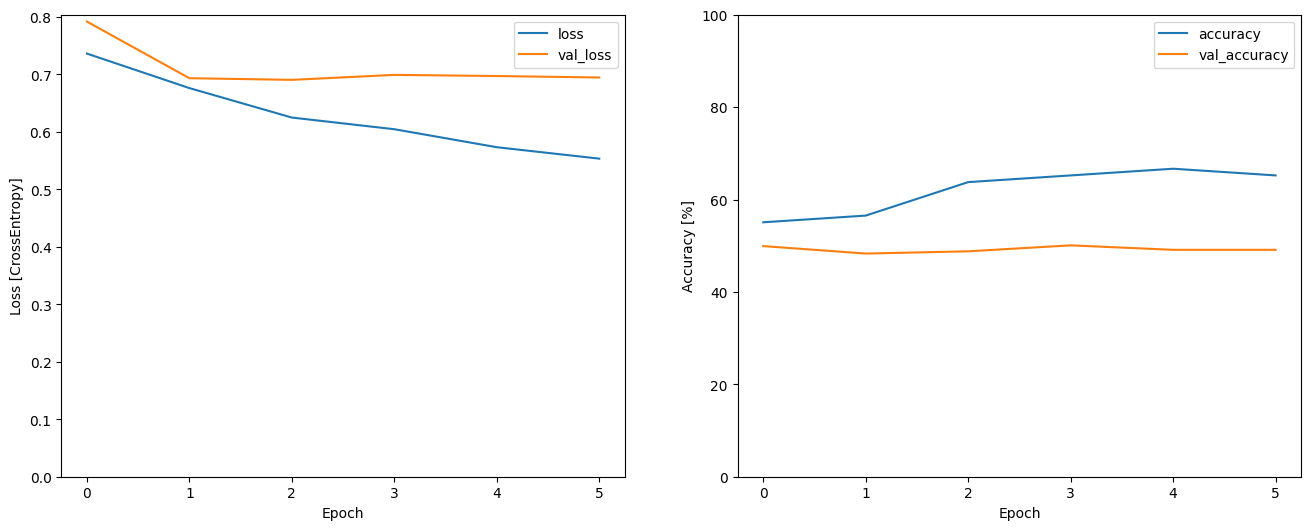

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
6/6 [==============================] - 1s 86ms/step - loss: 1.7863 - accuracy: 0.4493 - val_loss: 0.8043 - val_accuracy: 0.5089
Epoch 2/20
6/6 [==============================] - 0s 58ms/step - loss: 1.0026 - accuracy: 0.5652 - val_loss: 1.1290 - val_accuracy: 0.5057
Epoch 3/20
6/6 [==============================] - 0s 50ms/step - loss: 0.7910 - accuracy: 0.5652 - val_loss: 0.6837 - val_accuracy: 0.5299
Epoch 4/20
6/6 [==============================] - 0s 57ms/step - loss: 0.6925 - accuracy: 0.5507 - val_loss: 0.6752 - val_accuracy: 0.6381
Epoch 5/20
6/6 [==============================] - 0s 67ms/step - loss: 0.6578 - accuracy: 0.5362 - val_loss: 0.7053 - val_accuracy: 0.5186
Epoch 6/20
6/6 [==============================] - 0s 65ms/step - loss: 0.6688 - accuracy: 0.5072 - val_loss: 0.6650 - val_accuracy: 0.5218


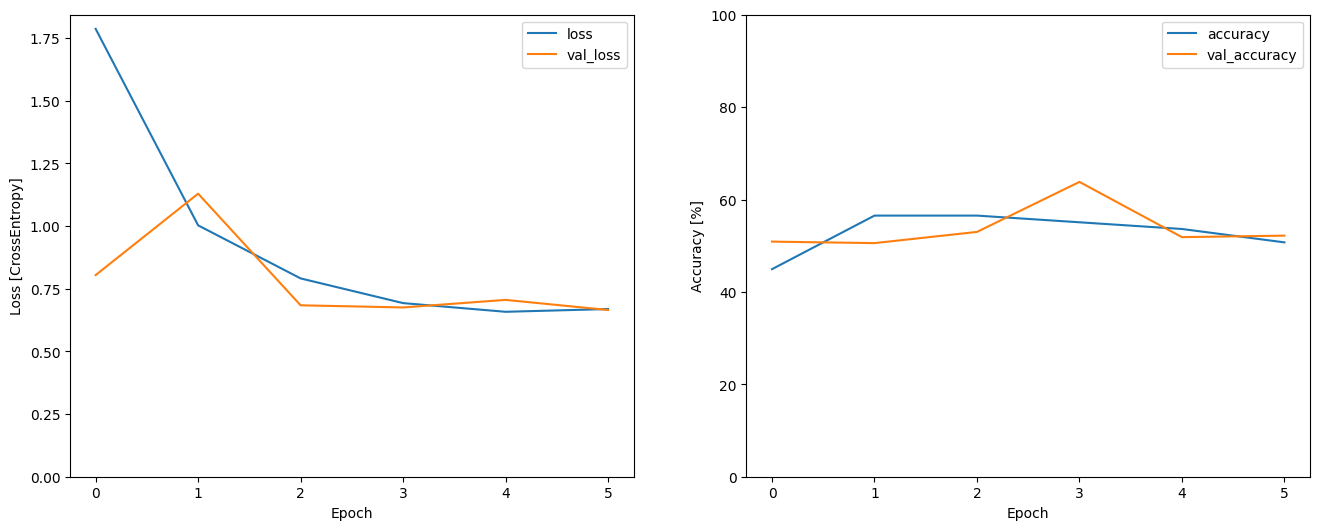

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

52/52 [==============================] - 0s 7ms/step - loss: 2.1776 - accuracy: 0.5024
MFCC Seq: [2.177644968032837, 0.5024232864379883]
52/52 [==============================] - 0s 4ms/step - loss: 0.8523 - accuracy: 0.4927
MFCC Conv: [0.8523181080818176, 0.49273020029067993]
52/52 [==============================] - 0s 7ms/step - loss: 3.8049 - accuracy: 0.4685
Spec Seq: [3.8048763275146484, 0.4684975743293762]
52/52 [==============================] - 0s 5ms/step - loss: 6.8451 - accuracy: 0.5024
Spec Conv: [6.845094203948975, 0.5024232864379883]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
6/6 [==============================] - 1s 88ms/step - loss: 3.7749 - accuracy: 0.4783 - val_loss: 1.9467 - val_accuracy: 0.6801
Epoch 2/20
6/6 [==============================] - 0s 72ms/step - loss: 1.0660 - accuracy: 0.7536 - val_loss: 0.8648 - val_accuracy: 0.6801
Epoch 3/20
6/6 [==============================] - 0s 72ms/step - loss: 0.5901 - accuracy: 0.8116 - val_loss: 0.8773 - val_accuracy: 0.6591
Epoch 4/20
6/6 [==============================] - 0s 72ms/step - loss: 0.3218 - accuracy: 0.8986 - val_loss: 0.7656 - val_accuracy: 0.7674
Epoch 5/20
6/6 [==============================] - 0s 72ms/step - loss: 0.4125 - accuracy: 0.8551 - val_loss: 0.8143 - val_accuracy: 0.7722
Epoch 6/20
6/6 [==============================] - 0s 72ms/step - loss: 0.1213 - accuracy: 0.9710 - val_loss: 0.6868 - val_accuracy: 0.7011
Epoch 7/20
6/6 [==============================] - 0s 71ms/step - loss: 0.1772 - accuracy: 0.9275 - val_loss: 0.7236 - val_accuracy: 0.6947


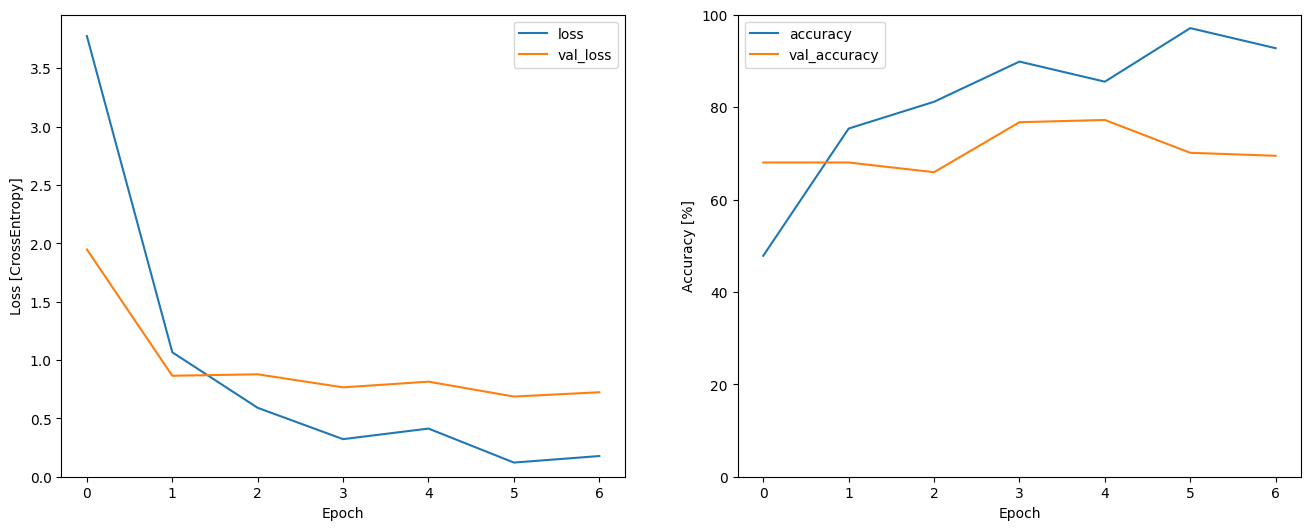

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
6/6 [==============================] - 0s 43ms/step - loss: 0.9960 - accuracy: 0.4638 - val_loss: 0.7998 - val_accuracy: 0.5299
Epoch 2/20
6/6 [==============================] - 0s 31ms/step - loss: 0.8706 - accuracy: 0.5652 - val_loss: 0.7124 - val_accuracy: 0.6721
Epoch 3/20
6/6 [==============================] - 0s 31ms/step - loss: 0.7754 - accuracy: 0.5797 - val_loss: 0.7108 - val_accuracy: 0.5913
Epoch 4/20
6/6 [==============================] - 0s 30ms/step - loss: 0.6830 - accuracy: 0.6522 - val_loss: 0.6432 - val_accuracy: 0.6591
Epoch 5/20
6/6 [==============================] - 0s 31ms/step - loss: 0.5433 - accuracy: 0.7101 - val_loss: 0.6682 - val_accuracy: 0.6268
Epoch 6/20
6/6 [==============================] - 0s 31ms/step - loss: 0.5108 - accuracy: 0.7246 - val_loss: 0.6191 - val_accuracy: 0.7092
Epoch 7/20
6/6 [==============================] - 0s 30ms/step - loss: 0.3925 - accuracy: 0.7971 - val_loss: 0.6759 - val_accuracy: 0.6074
Epoch 8/20
6/6 [===========

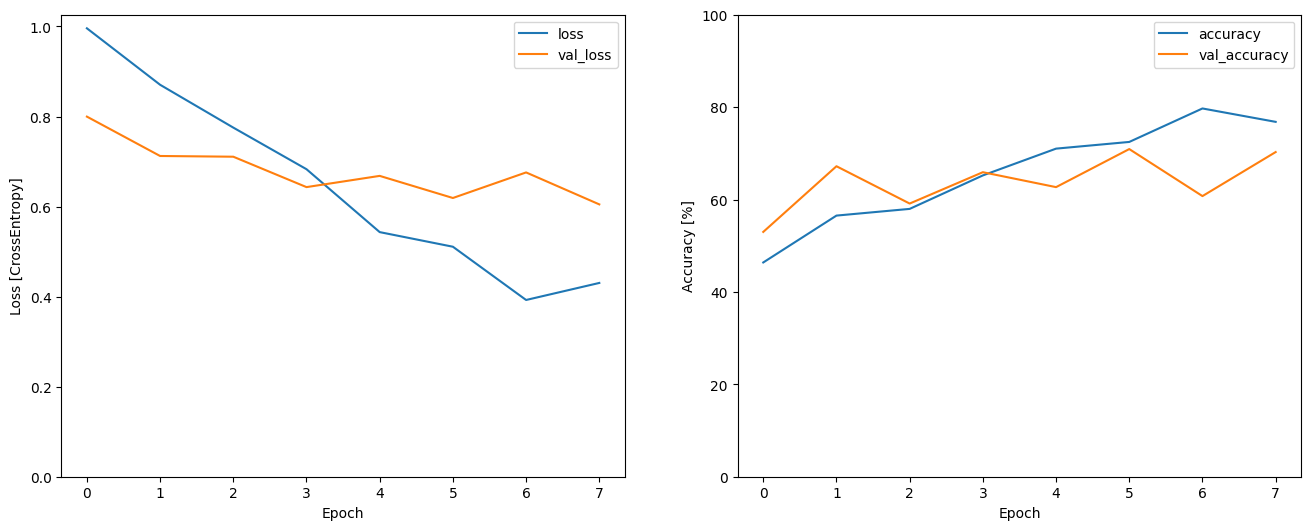

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
6/6 [==============================] - 1s 88ms/step - loss: 3.8384 - accuracy: 0.4348 - val_loss: 2.7662 - val_accuracy: 0.4943
Epoch 2/20
6/6 [==============================] - 0s 73ms/step - loss: 2.8941 - accuracy: 0.5217 - val_loss: 1.2937 - val_accuracy: 0.5024
Epoch 3/20
6/6 [==============================] - 0s 74ms/step - loss: 1.3569 - accuracy: 0.6377 - val_loss: 1.0082 - val_accuracy: 0.5331
Epoch 4/20
6/6 [==============================] - 0s 73ms/step - loss: 0.8994 - accuracy: 0.6232 - val_loss: 0.9593 - val_accuracy: 0.5202
Epoch 5/20
6/6 [==============================] - 0s 73ms/step - loss: 0.6189 - accuracy: 0.7101 - val_loss: 1.0482 - val_accuracy: 0.5267
Epoch 6/20
6/6 [==============================] - 0s 73ms/step - loss: 0.4891 - accuracy: 0.7826 - val_loss: 0.9320 - val_accuracy: 0.5557
Epoch 7/20
6/6 [==============================] - 0s 78ms/step - loss: 0.3304 - accuracy: 0.8551 - val_loss: 0.7197 - val_accuracy: 0.6575
Epoch 8/20
6/6 [===========

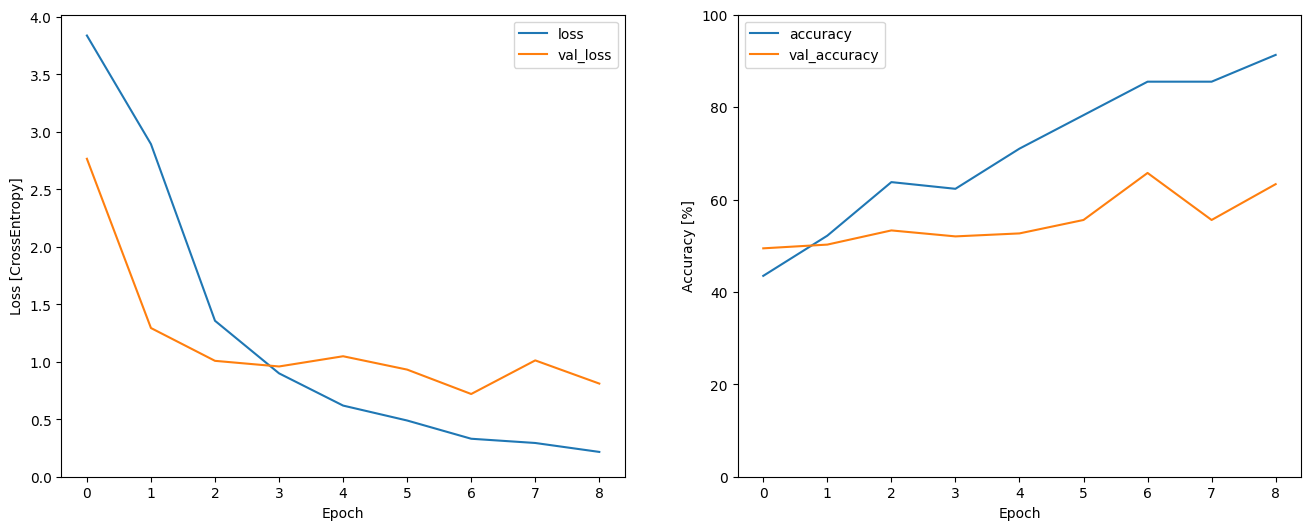

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
6/6 [==============================] - 1s 76ms/step - loss: 4.2346 - accuracy: 0.5072 - val_loss: 4.2621 - val_accuracy: 0.5024
Epoch 2/20
6/6 [==============================] - 0s 44ms/step - loss: 1.7676 - accuracy: 0.5652 - val_loss: 0.9517 - val_accuracy: 0.5460
Epoch 3/20
6/6 [==============================] - 0s 42ms/step - loss: 0.8270 - accuracy: 0.4783 - val_loss: 0.7678 - val_accuracy: 0.5057
Epoch 4/20
6/6 [==============================] - 0s 44ms/step - loss: 0.6831 - accuracy: 0.5652 - val_loss: 0.6790 - val_accuracy: 0.5428
Epoch 5/20
6/6 [==============================] - 0s 44ms/step - loss: 0.6666 - accuracy: 0.5652 - val_loss: 0.6690 - val_accuracy: 0.6397
Epoch 6/20
6/6 [==============================] - 0s 50ms/step - loss: 0.6537 - accuracy: 0.6377 - val_loss: 0.6734 - val_accuracy: 0.5913
Epoch 7/20
6/6 [==============================] - 0s 54ms/step - loss: 0.6852 - accuracy: 0.5797 - val_loss: 0.7033 - val_accuracy: 0.5057


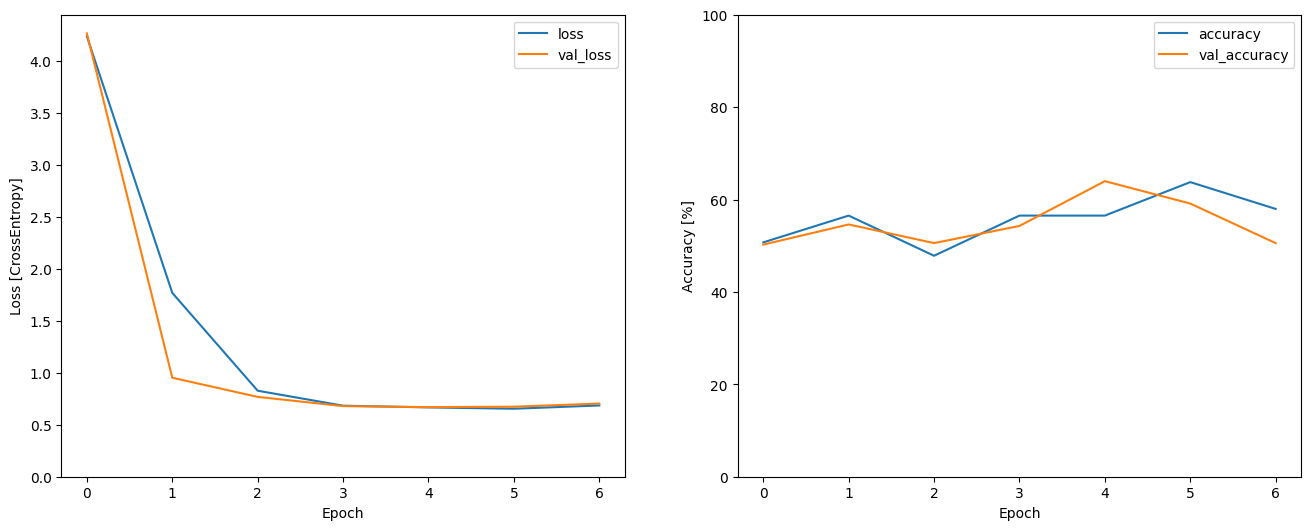

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
